<a href="https://colab.research.google.com/github/shanikairoshi/Quantum_Teleportation_With_Noise/blob/main/Teleported_With_Low_Noise_DQFL_Genome_Non_IID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Why separate circuits?

Purpose and Functionality: The QNN and teleportation circuits serve different purposes and have distinct functionalities:
QNN Circuit: Used for building and training a quantum neural network model for classification or regression tasks. It focuses on encoding data, applying parameterized transformations, and measuring outcomes to make predictions.
Teleportation Circuit: Designed specifically to transmit quantum information (in this case, model parameters) between two parties. It involves entanglement, Bell measurements, and conditional corrections to transfer the quantum state of one qubit to another.
Structure: The inherent structures of these circuits differ significantly:
QNN Circuit: Composed of a feature map and an ansatz, which can vary depending on the problem and model architecture. It often involves a sequence of parameterized gates applied to qubits representing input features.
Teleportation Circuit: Typically consists of three qubits and classical bits arranged in a specific configuration to facilitate the teleportation protocol. It involves controlled operations and measurements to transfer quantum states.
Independence: While conceptually connected within your DUQFL framework, the QNN and teleportation circuits operate independently. The QNN circuit is responsible for model training on local data, and the teleportation circuit is utilized to share model updates between clients.
How are they connected?

Parameter Transfer: The connection between these two concepts lies in the transfer of model parameters:
Extracting Parameters: After training the QNN model on a client's data, the optimized parameters (weights) are extracted.
Teleportation: These parameters are then "teleported" (in your simplified simulation) using the teleportation circuit. The parameter values are encoded onto qubits, and the teleportation process attempts to transfer these states to the receiver.
Updating Global Model: The teleported parameters are used to update the global model, which is subsequently shared with other clients. This enables information sharing and collaboration among clients without directly exchanging classical data.
In your code:

Separate Functions: The QNN circuit is defined within the initialize_model function, while the teleportation circuit is defined inside the teleport_parameter function.
Integration within Federated Learning: The connection happens within the federated learning loop, where after identifying the best client's model, its parameters are extracted and "teleported" before updating other clients' models.
In summary:

Separate quantum circuits are essential due to the different purposes and structures of QNN and teleportation.
The connection lies in using teleportation to transmit model parameters, facilitating information sharing in federated learning.
Your code demonstrates this connection by incorporating both circuits within the federated learning loop, although the teleportation implementation is a simplified simulation.

In [1]:
!pip install qiskit-terra==0.24.1 qiskit-aer==0.12.0 qiskit-ibmq-provider==0.20.2 qiskit==0.43.1 qiskit-machine-learning==0.6.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━

We are going to implement telepotation to establish a communication between clients.

Here are the integration steps:

##Model Update Encoding:
After a federated round, choose the best client’s model. Extract its parameter vector—representing the critical update—and encode each parameter as a quantum state. In our simplified version, we use an RX rotation on a qubit where the rotation angle is determined by the parameter value.

##Quantum Teleportation:
For each parameter (or for a group of parameters, if you build a multi‑qubit circuit), use a teleportation circuit. In our demonstration, we build a function that creates a teleportation circuit to “transfer” the encoded value. In practice, the protocol would need to generate an entangled pair between sender and receiver, perform a Bell measurement, and then use classical communication to apply the correction on the receiver’s side.

##Update Transfer:
Replace or update the global model’s parameters with the teleported values. Then distribute these updated parameters to all the participating clients.

##noise Level

        Setting	            p1	      p2	   Result Observation
        Low noise (ideal)	  0.001	0.005	  Benchmark "almost ideal" behavior
        Medium noise	      0.005	0.015   Observe degradation, fairness
        High noise	        0.01	0.02	  Worst-case robustness


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 359.2 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:

%%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer
!pip install qiskit
!pip install qiskit_machine_learning

In [ ]:
import qiskit.primitives
print(dir(qiskit.primitives))

['BackendEstimator', 'BackendSampler', 'BaseEstimator', 'BaseSampler', 'Estimator', 'EstimatorResult', 'Sampler', 'SamplerResult', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'backend_estimator', 'backend_sampler', 'base', 'estimator', 'primitive_job', 'sampler', 'utils']


In [11]:

import os
from datetime import datetime
import time
import csv
from tqdm import tqdm


# ─── 0. Capture the start timestamp ────────────────────────────────────────────
start_ts   = datetime.now()
# Format as “DD_MM_YYYY_HHMMSS” (no colons, so filesystem‑safe)
start_str  = start_ts.strftime("%d_%m_%Y_%H%M%S")

# ─── 1. Experiment configuration ───────────────────────────────────────────────
'''
num_epochs = 10 #50
max_train_iterations = 100
samples_per_epoch=100 #10
word_size = 40
use_teleportation             = True   # or False/True
use_noise =True
'''
num_epochs = 10 #50
max_train_iterations = 100
samples_per_epoch=100 #10
word_size = 40
use_teleportation             = True   # or False/True
use_noise =True


num_clients = 5 #8 test with teleport
num_federated_layers = 10
num_deep_unfolding_iterations = 5
initial_learning_rate = 0.15
meta_learning_rate=1e-4
initial_perturbation = 0.15
momentum = 0.95
gradient_moving_avg = 0

# Define federated learning with accuracy tracking
num_features = 5
global_model_weights, global_model_accuracy = {}, []
clients_train_accuracies, clients_test_accuracies = [], []
round_times = []
overall_start = time.time()


# ─── 2. Helper to make floats filesystem‑safe (“0.15” → “0p15”) ─────────────────
def fmt(x: float) -> str:
    return str(x).replace('.', 'p')

# ─── 3. Build the hyperparameter string ───────────────────────────────────────
param_str = (
    f"clients{num_clients}"
    f"_layers{num_federated_layers}"
    f"_du{num_deep_unfolding_iterations}"
    f"_lr{fmt(initial_learning_rate)}"
    f"_pert{fmt(initial_perturbation)}"
)

# ─── 4. Date stamp and Teleport flag ───────────────────────────────────────────
date_str    = datetime.now().strftime("%d_%m_%Y")               # e.g. "22_04_2025"
teleport_pl = "Teleport" if use_teleportation else "NoTeleport"
noise = "WithNoise" if use_noise else "NoNoise"

# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
drive_root = "/content/drive/MyDrive"


#  a) Best‑client CSV
best_client_csv_file = os.path.join(
    drive_root,
    f"DQFL_Genome_Low_Noise_nonIID_Best_Client_{date_str}_{teleport_pl}_{noise}_{param_str}.csv"
)

#  b) Global‑accuracy CSV
global_csv_file = os.path.join(
    drive_root,
    f"DQFL_Genome_Low_Noise_nonIID_Global_{date_str}_{teleport_pl}_{noise}_{param_str}.csv"
)

#  c) Local CSV
csv_file = os.path.join(
    drive_root,
    f"DQFL_Genome_Low_Noise_nonIID_Local_{date_str}_{teleport_pl}_{noise}_{param_str}.csv"
)

validation_csv_file = os.path.join(
    drive_root,
    f"DQFL_Genome_Low_Noise_nonIID_validation_Loss_{date_str}_{teleport_pl}_{noise}_{param_str}.csv"
)


In [12]:

from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
#from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
from qiskit_aer import Aer

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

from qiskit_algorithms.optimizers import SPSA
import numpy as np
import time
#from IPython.display import clear_output
import matplotlib.pyplot as plt
from qiskit_algorithms.utils import algorithm_globals # Import algorithm_globals

import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split


# Set random seed for reproducibility using algorithm_globals
algorithm_globals.random_seed = 42  # Set seed globally


test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)


from collections import defaultdict
import numpy as np


word_combinations = defaultdict(int)
iteration = 1
for text, _ in data_set:
    for i in range(len(text)):
        word = text[i:i+word_size]
        if word_combinations.get(word) is None:
          word_combinations[word] = iteration
          iteration += 1



print("First sample int the data_set variable: ")
print(data_set[0])

print("\nFirst 5 samples in the word_combinations dict.")
for key, value in list(word_combinations.items())[:5]:
    print(key, value)


import numpy as np
# Preprocess the training set
np_data_set = []
for i in range(len(data_set)):
    sequence, label = data_set[i]
    sequence = sequence.strip()  # Remove any leading/trailing whitespace
    words = [sequence[i:i + word_size] for i in range(0, len(sequence), word_size)]  # Split the sequence into 4-letter words
    int_sequence = np.array([word_combinations[word] for word in words])
    data_point = {'sequence': int_sequence, 'label': label}
    np_data_set.append(data_point)


print("First 5 samples of encoded data:")
np_data_set[:5]


np.random.shuffle(np_data_set)
print("First 5 samples of encoded shuffled data:")
np_data_set[:5]
from sklearn.preprocessing import MinMaxScaler

sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = MinMaxScaler()

sequences_scaled = scaler.fit_transform(sequences)

for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_scaled[i]

print("First 5 samples of scaled encoded shuffled data:")
np_data_set[:5]



First sample int the data_set variable: 
('GCAGAAGATAGGGCAGGATGTGGCTTCGGTGTCCAGGGCAGGAGAGGAGGGAGCAGCCCGGGTGGGCAAGGCTGTGAAGGAGGCTGCTGCGCTGCCCCACGGGGCCATGGTTAGGTCCAGCAGAAAGGGCGGAAGGGGTGCACTGGGCATGGCCTCTACTCATATGCCAGCTCTGAGCCTCTGGAAATCCACATTTGGTT', 0)

First 5 samples in the word_combinations dict.
GCAGAAGATAGGGCAGGATGTGGCTTCGGTGTCCAGGGCA 1
CAGAAGATAGGGCAGGATGTGGCTTCGGTGTCCAGGGCAG 2
AGAAGATAGGGCAGGATGTGGCTTCGGTGTCCAGGGCAGG 3
GAAGATAGGGCAGGATGTGGCTTCGGTGTCCAGGGCAGGA 4
AAGATAGGGCAGGATGTGGCTTCGGTGTCCAGGGCAGGAG 5
First 5 samples of encoded data:
First 5 samples of encoded shuffled data:
First 5 samples of scaled encoded shuffled data:


[{'sequence': array([0.38837014, 0.02930736, 0.3883697 , 0.38836912, 0.38836912]),
  'label': 0},
 {'sequence': array([0.52944336, 0.52944336, 0.52944336, 0.52944336, 0.52944336]),
  'label': 1},
 {'sequence': array([0.95763488, 0.95763488, 0.95763488, 0.95763488, 0.95763488]),
  'label': 1},
 {'sequence': array([0.44629369, 0.44629369, 0.44629369, 0.44629369, 0.44629369]),
  'label': 0},
 {'sequence': array([0.60917208, 0.60917208, 0.60917208, 0.60917208, 0.60917208]),
  'label': 1}]

In [13]:

global_seed = 42  # You can choose any integer value for the seed

# 5) Split into federated train vs central validation
train_frac = 0.9
train_list, central_val = train_test_split(
    np_data_set, train_size=train_frac, random_state=global_seed,
    stratify=[d['label'] for d in np_data_set]
)
X_val = np.stack([d['sequence'] for d in central_val])
y_val = np.array([d['label'] for d in central_val])
print(f"Train for federated: {len(train_list)}, central val: {len(central_val)}")


np_train_data = train_list[:5000]
np_test_data = np_data_set[-200:]

print(f"Length of sample train data for FL: {len(np_train_data)}")
print(f"Length of sample test data for FL: {len(np_test_data)}")

test_sequences = [data_point["sequence"] for data_point in np_test_data]
test_labels = [data_point["label"] for data_point in np_test_data]
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)




Train for federated: 67500, central val: 7500
Length of sample train data for FL: 5000
Length of sample test data for FL: 200


Quantity and label non-iid ness


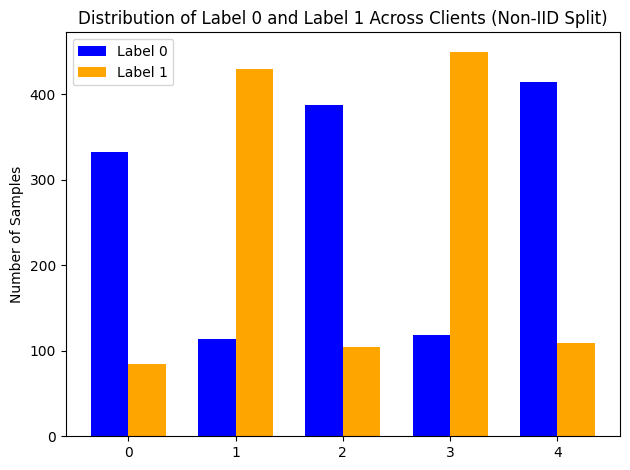

In [14]:
import random
import matplotlib.pyplot as plt
import numpy as np

class Client:
    def __init__(self, data, test_data):  # Add test_data to __init__
        self.data = data
        self.test_data = test_data  # Store test_data as an attribute
        self.models = []
        self.train_scores = []
        self.test_scores = []
        self.primary_model = None



def split_dataset_quantity_non_iid_binary(dataset, num_clients, num_epochs, samples_per_epoch, non_iid_ratio=0.5, quantity_variation=0.2):
    """
    Splits a binary-labeled dataset into non-IID partitions among clients, varying the quantity of data.

    Args:
        dataset: list of dicts with 'features' and 'label'.
        num_clients: total number of clients.
        num_epochs: number of epochs.
        samples_per_epoch: base samples assigned to each client per epoch.
        non_iid_ratio: how skewed (0.5 = balanced, 1.0 = completely biased to one label).
        quantity_variation: how much to vary the quantity of data per client (0.0 = no variation, 1.0 = up to double the base samples).
    """
    label_0 = [sample for sample in dataset if sample["label"] == 0]
    label_1 = [sample for sample in dataset if sample["label"] == 1]
    random.shuffle(label_0)
    random.shuffle(label_1)

    client_label_0_counts = []
    client_label_1_counts = []

    # Create Client objects and assign data to them
    clients_data = []

    for client_id in range(num_clients):
        client_data = []
        selected_label_0 = []
        selected_label_1 = []
        # Track the number of labels assigned to each client
        client_label_0_count = 0
        client_label_1_count = 0

        for epoch in range(num_epochs):
            # Vary the quantity of data per client
            epoch_samples = int(samples_per_epoch * (1 + random.uniform(-quantity_variation, quantity_variation)))

            if client_id % 2 == 0:  # Even client gets a higher proportion of label 0
                num_label_0 = int(epoch_samples * non_iid_ratio)
                num_label_1 = epoch_samples - num_label_0
            else:  # Odd client gets a higher proportion of label 1
                num_label_1 = int(epoch_samples * non_iid_ratio)
                num_label_0 = epoch_samples - num_label_1

            # Select the required number of samples for each label
            selected_label_0 = label_0[:num_label_0]
            selected_label_1 = label_1[:num_label_1]

            # Update the remaining dataset
            label_0 = label_0[num_label_0:]
            label_1 = label_1[num_label_1:]

            # Update counts for label distribution
            client_label_0_count += num_label_0
            client_label_1_count += num_label_1

            # Append data for the current epoch to the client's data
            client_data.append(selected_label_0 + selected_label_1);

        # Store the final counts for the client
        client_label_0_counts.append(client_label_0_count)
        client_label_1_counts.append(client_label_1_count)

        clients_data.append(client_data)  # Append client's data for all epochs



    # Plotting the results
    clients = list(range(num_clients))
    width = 0.35  # the width of the bars
    x = np.arange(len(clients))  # the label locations

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, client_label_0_counts, width, label='Label 0', color='blue')
    rects2 = ax.bar(x + width/2, client_label_1_counts, width, label='Label 1', color='orange')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of Samples')
    ax.set_title(f'Distribution of Label 0 and Label 1 Across Clients (Non-IID Split)')
    ax.set_xticks(x)
    ax.set_xticklabels(clients)
    ax.legend()

    fig.tight_layout()

    plt.show()
    return clients_data # Return the clients data

# Example usage
#dataset = [{'features': [random.random(), random.random()], 'label': random.choice([0, 1])} for _ in range(1000)]
clients=[]# Initialize the list of Client objects
client_data_list =split_dataset_quantity_non_iid_binary(
  dataset=np_train_data,
  num_clients=5,
  num_epochs=10,
  samples_per_epoch=50,
  non_iid_ratio=0.8,  # 0.5, 0, 1.0
  quantity_variation=0.5) #


for client_data in client_data_list:
    client = Client(client_data, test_data=np_test_data)
    clients.append(client)


Split data into validation and train set

Data Load and preprocessing

In [15]:

import csv
import numpy as np
import time
import matplotlib.pyplot as plt
#from IPython.display import clear_output
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import BackendSampler
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import log_loss
from tqdm import tqdm


# Callback function to capture the loss values
objective_func_vals = []  # Global list to store loss values
learning_rates = []
perturbations = []
# Data structure for tracking per-client, per-layer objective function values


In [16]:


import os  # For handling directories

# Define the directory to save the plots
output_dir = "federated_round_plots"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
# Initialize a global variable to track the round number
current_round = 1

# Callback for visualization, gradient smoothing, and learning rate adjustment in deep unfolding
def deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients=None,round_number=0):
    global gradient_moving_avg, learning_rates, perturbations,current_round

    #clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # If gradients are provided, smooth the gradient using momentum
    if gradients is not None:
        gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients  # Apply moving average
        delta_lr = 0.05 * gradient_moving_avg  # Adjust learning rate based on the smoothed gradient
        delta_perturbation = 0.1 * gradient_moving_avg  # Adjust perturbation based on the same gradient
    else:
        delta_lr = 0  # No gradient info available in this iteration
        delta_perturbation = 0

    # Update learning rate and perturbation
    if len(learning_rates) > 0:
        new_lr = max(0.001, learning_rates[-1] + delta_lr)  # Ensure learning rate is positive and non-zero
        new_perturbation = max(0.001, perturbations[-1] + delta_perturbation)  # Ensure perturbation is positive
    else:
        new_lr = initial_learning_rate
        new_perturbation = initial_perturbation

    learning_rates.append(new_lr)
    perturbations.append(new_perturbation)

    import matplotlib.pyplot as plt

    # Visualization of learning rate and perturbation
    plt.figure(figsize=(10, 12))  # Adjust figure size for better spacing

    # Plot Objective Function Value
    plt.subplot(3, 1, 1)
    plt.plot(range(len(objective_func_vals)), objective_func_vals, label="Objective Function Value", color='blue')
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Objective Function Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)  # Add grid for better readability

    # Plot Learning Rate
    plt.subplot(3, 1, 2)
    plt.plot(range(len(learning_rates)), learning_rates, label="Learning Rate", color='green')
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)

    # Plot Perturbation
    plt.subplot(3, 1, 3)
    plt.plot(range(len(perturbations)), perturbations, label="Perturbation", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Perturbation")
    plt.title("Perturbation Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)

    plt.tight_layout(pad=3.0)  # Add padding between subplots
    # Save the plot after each federated round
    #plot_filename = os.path.join(output_dir, f"federated_round_{current_round}.png")
    #plt.savefig(plot_filename)  # Save the figure
    #plt.show()
    plt.close()  # Close the plot to free memory

    # Increment the round number for the next call
    current_round += 1


# Define the SPSA callback to capture gradients and update learning rate and perturbation dynamically
def spsa_callback(nfev, parameters, obj_func_eval, stepsize, accept):
    # Assuming `stepsize` contains gradient information or its approximation
    gradients = stepsize
    deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients)

# Custom SPSA optimizer with learnable learning rate and perturbation
class LearnableLRPerturbationSPSA(SPSA):
    def __init__(self, initial_lr=1e-4, initial_perturbation=0.01, lr_alpha=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = initial_lr  # Initial learning rate
        self.perturbation = initial_perturbation  # Initial perturbation
        self.lr_alpha = lr_alpha  # Learning rate and perturbation update speed

    def _update_learning_rate_and_perturbation(self, gradient, obj_func_eval):
        """
        Update both learning rate and perturbation based on gradient and objective function evaluation.
        The learning rate increases if the objective function improves and decreases otherwise.
        """
        # Use the gradient sign to determine if we should increase or decrease
        grad_lr = np.sign(np.mean(gradient))  # Average gradient sign across parameters

        if grad_lr > 0:  # Objective function is improving
            self.lr += self.lr_alpha * abs(grad_lr)  # Increase learning rate
            self.perturbation += self.lr_alpha * abs(grad_lr)  # Increase perturbation
        else:  # Objective function is getting worse
            self.lr -= self.lr_alpha * abs(grad_lr)  # Decrease learning rate
            self.perturbation -= self.lr_alpha * abs(grad_lr)  # Decrease perturbation

        # Ensure both learning rate and perturbation are positive
        self.lr = max(0.001, self.lr)
        self.perturbation = max(0.001, self.perturbation)

    def step(self, gradient, obj_func_eval):
        """
        Perform optimization step for both parameters, learning rate, and perturbation.
        Use the objective function evaluation to dynamically adjust learning rate and perturbation.
        """
        self._update_learning_rate_and_perturbation(gradient, obj_func_eval)
        return super().step(gradient)  # Perform SPSA step for parameters

    def reset(self):
        """
        Reset the optimizer state (learning rates, perturbations, and gradient moving averages) for the next round.
        """
        self.lr = initial_learning_rate
        self.perturbation = initial_perturbation
        self.gradient_moving_avg = 0  # Reset the moving average of the gradient
        learning_rates.clear()  # Reset the learning rates history
        perturbations.clear()  # Reset the perturbations history
        objective_func_vals.clear()  # Clear the objective function history

In [17]:
# Create optimizer with learnable learning rate and perturbation
spsa_optimizer = LearnableLRPerturbationSPSA(
      maxiter=25, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=spsa_callback, lr_alpha=0.01
)

In [18]:

#======================================================
# Initialize QNN model
def initialize_model(num_features,initial_params):
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    qc = feature_map.compose(ansatz)

    # Create optimizer with learnable learning rate and perturbation
    #spsa_optimizer = LearnableLRPerturbationSPSA(
     #maxiter=25, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=spsa_callback, lr_alpha=0.01
#)
    global spsa_optimizer
    def parity(x):
        return "{:b}".format(x).count("1") % 2

    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=2,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )


    # Define the neural network classifier
    qnn_classifier = NeuralNetworkClassifier(
      neural_network=sampler_qnn,
      optimizer=spsa_optimizer,
      loss='squared_error',
      initial_point=initial_params,  # Initialize with the starting parameters
)


    return qnn_classifier

#=====================================================
from google.colab import drive
import csv
# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the save path in Google Drive
#csv_file = '/content/drive/My Drive/DQFL_Genome_IID_22_04_2025_Teleport.csv'

# Step 3: Define headers for the CSV
headers = ["Federated Round", "Client Number", "Iteration", "Objective Function Value",
           "Training Accuracy", "Test Accuracy", "Learning Rate", "Perturbation"]

# Open the CSV file and write headers if it's the first time writing to the file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)

# Example of saving results for each federated round and client
def save_results(federated_round, client_id, iteration, obj_func_val, train_acc, test_acc, learning_rate, perturbation):
    with open(csv_file, mode='a', newline='') as file:  # Open file in append mode
        writer = csv.writer(file)
        writer.writerow([federated_round, client_id, iteration, obj_func_val, train_acc, test_acc, learning_rate, perturbation])
#=====================================================

# 7) Validation loss helper
def compute_validation_loss(model, X, y):
    """
    Compute the average cross-entropy loss on (X,y) using the QNN's output probabilities.
    Falls back to a direct forward call if predict_proba is unavailable.
    """
    try:
        # Preferred: scikit-like API if available
        proba = model.predict_proba(X)
    except AttributeError:
        # Fallback: extract weights and call the QNN forward method
        weights = model._fit_result.x
        proba = model._neural_network.forward(X, weights)
    return log_loss(y, proba)

#====================================================
# Federated learning loop per client
def train_qnn_model(client_data, client_test_data, model=None, client_id=None, layer=None):

    global learning_rates, perturbations, objective_func_vals
    print("Client Data Structure:")  # Add this line to print the structure
    print(client_data)                # This line prints the actual data
    print(type(client_data))           # This line prints the data type
    #num_features = client_data[0]["sequence"].shape[0]

    #initial_params = np.random.rand(RealAmplitudes(client_data.shape[1], reps=4).num_parameters)  # Initialize params
    initial_params = np.random.rand(RealAmplitudes(len(client_data[0]["sequence"]), reps=3).num_parameters)

    if model is None:
        model = initialize_model(num_features, initial_params)

    train_sequences = np.array([data_point["sequence"] for data_point in client_data])
    train_labels = np.array([data_point["label"] for data_point in client_data])
    test_sequences = np.array([data_point["sequence"] for data_point in client_test_data])
    test_labels = np.array([data_point["label"] for data_point in client_test_data])

    train_accuracies, test_accuracies, total_time = [], [], 0

    train_accuracies = []
    test_accuracies = []

    # Deep Unfolding with multiple iterations
    # Continue training with learned weights and adjust learning rate based on performance and gradients.
    total_time = 0
    current_params = initial_params  # Start with the initial parameters

    for i in range(num_deep_unfolding_iterations):
        print("\n")
        print(f"Deep Unfolding Iteration {i+1}/{num_deep_unfolding_iterations}")
        start_time = time.time()
        model.fit(train_sequences, train_labels)
        end_time = time.time()
        total_time += end_time - start_time

        # After training, retrieve the updated parameters from the optimizer
        current_params = model.weights
        print(f"Trained parameters after iteration {i+1}: {current_params}")

        # Store final weights and learning rate for next round
        final_learning_rate = learning_rates[-1]
        final_perturbation = perturbations[-1]

        # Evaluate the model performance
        train_accuracy = model.score(train_sequences, train_labels)
        test_accuracy = model.score(test_sequences, test_labels)

        # Store accuracies for future reference
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)


        # Write the results to the CSV file
        save_results(layer, client_id, i+1, objective_func_vals[-1], train_accuracy , test_accuracy , final_learning_rate, final_perturbation)

        #with open(csv_file, mode='a', newline='') as file:
          #writer = csv.writer(file)
         #writer.writerow([i+1, objective_func_vals[-1], train_accuracy * 100, test_accuracy * 100, final_learning_rate, final_perturbation])

        # Update the learning rate for the next iteration based on gradients from SPSA
        spsa_optimizer.learning_rate = learning_rates[-1]
        model.initial_point = current_params

        # Log performance
        print(f"Iteration {i+1} - Learning Rate: {final_learning_rate:.6f}")
        print(f"Iteration {i+1} - Training Accuracy: {train_accuracy:.2f}")
        print(f"Iteration {i+1} - Test Accuracy: {test_accuracy :.2f}")

    return model, train_accuracy, test_accuracy, total_time




Mounted at /content/drive


In [19]:
# Step to empty the CSV file before starting a new run
def clear_csv_file():
    """
    Clears the CSV file by overwriting it with headers or leaving it blank.
    """
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Uncomment the next line to write headers for the new run
        writer.writerow(headers)
        # Leave it blank if you prefer not to include headers
        # pass



In [20]:
def get_global_accuracy(model, val_sequences, val_labels):
    """
    Evaluate the accuracy of the given model on the test dataset.

    Parameters:
        model: The trained model to evaluate.
        num_features: The number of features in each data sample.
        test_sequences: A list or array of test input data (features).
        test_labels: A list or array of true labels corresponding to the test data.

    Returns:
        float: The accuracy of the model as a percentage.
    """
    global_accuracy = model.score(val_sequences, val_labels)
    return global_accuracy


In [21]:
def get_accuracy(model, test_sequences, test_labels):
    """
    Evaluate the accuracy of the given model on the test dataset.

    Parameters:
        model: The trained model to evaluate.
        num_features: The number of features in each data sample.
        test_sequences: A list or array of test input data (features).
        test_labels: A list or array of true labels corresponding to the test data.

    Returns:
        float: The accuracy of the model as a percentage.
    """
    test_accuracy = model.score(test_sequences, test_labels)
    return test_accuracy

# Function to extract numerical values of parameters
def extract_param_values(model):
    #param_values = []
    # Loop through each parameter in the circuit and get its bound value
    # Retrieve the circuit from the neural network
    circuit = model.neural_network.circuit

    # Extract the parameter values bound to the circuit
    # Use enumerate to get both index and parameter
    param_values = {param: circuit.parameters[i] for i, param in enumerate(circuit.parameters)}
    return param_values
#def set_param_values(model, param_values):
    # Retrieve the circuit from the neural network
    #circuit = model.neural_network.circuit

    # Use assign_parameters to update the parameter values
    #circuit.assign_parameters(param_values, inplace=True)
# Function to set numerical values of parameters back into the circuit
def set_param_values(model, param_values):
    # Assign the averaged parameter values back to the circuit
    parameter_dict = {param: value for param, value in zip(model.neural_network.circuit.parameters, param_values)}
    model.neural_network.circuit.assign_parameters(parameter_dict)


# Manually average the numerical values of the parameters across clients
def manual_average_weights(epoch_weights):
    # Initialize a list to store the summed weights (initialize with zeros)
    num_weights = len(epoch_weights[0])  # Number of weights in the model
    num_clients = len(epoch_weights)  # Number of clients

    # Initialize sum of weights to zero (assuming NumPy array or list of weights)
    summed_weights = np.zeros(num_weights)

    # Sum the weights from all clients
    for client_weights in epoch_weights:
        summed_weights += np.array(client_weights)

    # Compute the average by dividing the summed weights by the number of clients
    average_weights = summed_weights / num_clients

    return average_weights

def create_model_with_weights(weights):
    initial_params = np.random.rand(RealAmplitudes(num_features, reps=3).num_parameters)
    model = initialize_model(num_features,weights)
    #set_param_values(model, weights)  # Assign global weights to the model
    return model


In [22]:

# Function to save accuracies to CSV
def save_accuracies_to_csv(global_accuracies, clients_train_accuracies, clients_test_accuracies, filename='accuracies.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        header = ['Epoch', 'Global Accuracy']
        for i in range(len(clients_train_accuracies[0])):  # Assuming all clients have the same number of records
            header.append(f'Client {i} Train Accuracy')
            header.append(f'Client {i} Test Accuracy')
        writer.writerow(header)

        # Write the accuracy data for each epoch
        for epoch in range(len(global_accuracies)):
            row = [epoch, global_accuracies[epoch]]  # Start with epoch and global accuracy
            for client_index in range(len(clients_train_accuracies[epoch])):
                row.append(clients_train_accuracies[epoch][client_index])  # Add train accuracy for client
                row.append(clients_test_accuracies[epoch][client_index])   # Add test accuracy for client
            writer.writerow(row)


#Start Implementing Telepotation

# A. Implementing a Simplified Teleportation for a Single Parameter

Add a helper function (or functions) to encode and “teleport” one parameter. In a real implementation we would need to work with multi‑qubit circuits and extract continuous (analog) variables via state tomography. Here we simulate with a single‑qubit circuit where we assume that the parameter is recovered perfectly.

Without adding noise model run as follows.

Add noise model

In [23]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel, errors
import matplotlib.pyplot as plt
import numpy as np

def teleport_parameter(val, show_histogram=False, use_noise=False):
    """
    Simulated teleportation of a single parameter with an option to add noise.

    Args:
        val (float): The parameter value to teleport.
        show_histogram (bool): If True, display the histogram of measurement outcomes.
        use_noise (bool): If True, execute the circuit with an added noise model.

    Returns:
        float: The parameter value (assumed to be perfectly transmitted ideally).
    """
    qc = QuantumCircuit(3, 2)

    # --- Encode the parameter on qubit 0 ---
    qc.rx(val, 0)

    # --- Prepare an entangled pair ---
    qc.h(1)
    qc.cx(1, 2)

    # --- Bell-State Measurement ---
    qc.cx(0, 1)
    qc.h(0)
    qc.measure([0, 1], [0, 1])

    # --- Conditional Corrections on qubit 2 ---
    qc.cx(1, 2).c_if(qc.cregs[0], 1)
    qc.cz(0, 2).c_if(qc.cregs[0], 2)

    backend = Aer.get_backend('qasm_simulator')

    # Define a noise model
    noise_model = None
    if use_noise:
      # define matching errors ,Define separate error objects for your single‑ and two‑qubit gates.
      #Attach each error only to gates of the matching size.
       #1% depolarizing on single‑qubit gates
        one_q_error = errors.depolarizing_error(0.001, 1)
        # e.g. 2% depolarizing on two‑qubit gates ( can choose a different rate)
        two_q_error = errors.depolarizing_error(0.005, 2)

        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(one_q_error, ['rx', 'h'])
        noise_model.add_all_qubit_quantum_error(two_q_error, ['cx'])

        # Add a depolarizing error to single-qubit gates with probability 1%
        #error = errors.depolarizing_error(0.01, 1)
        #oise_model.add_all_qubit_quantum_error(error, ['rx', 'h', 'cx'])

    result = execute(qc, backend, shots=1024, noise_model=noise_model).result()
    counts = result.get_counts(qc)

    if show_histogram:
        plot_histogram(counts)
        plt.show()

    # In an ideal simulation, we assume perfect transmission
    # If noise is applied,  can compare the output statistics.
    return val

def teleport_parameters(params, show_histogram=False, use_noise=False):
    """
    Applies the teleportation process to a vector of parameters.

    Each parameter is processed individually. The optional noise parameter
    allows you to simulate realistic transmission errors.

    Args:
        params (array-like): A vector of parameters.
        show_histogram (bool): If True, display the histogram for each parameter.
        use_noise (bool): If True, simulate noise in the circuit execution.

    Returns:
        np.array: The array of transmitted parameter values.
    """
    teleported = [teleport_parameter(p, show_histogram, use_noise) for p in params]
    return np.array(teleported)


<ipython-input-23-f98a118d4c38>:3: DeprecationWarning: Importing from 'qiskit.providers.aer' is deprecated. Import from 'qiskit_aer' instead, which should work identically.
  from qiskit.providers.aer.noise import NoiseModel, errors


Implement entanglement

#B. Integrating Teleportation into the Federated Learning Loop
Within our federated learning loop, once we have determined the best client's model and before updating all clients, implement to “teleport” the model’s parameter update.

#More  implement ->error correction, state tomography, and the complications of multi‑qubit encoding.

Federated Learning Setup

In [24]:
# Display information about the data assigned to each client, including epoch-wise splits
for idx, client in enumerate(clients):
    print(f"Client {idx + 1}:")
    for epoch in range(num_epochs):
        print(f"  Epoch {epoch + 1}: Train data samples: {len(client.data[epoch])}")
    print(f"  Test data samples: {len(client.test_data)}")


Client 1:
  Epoch 1: Train data samples: 25
  Epoch 2: Train data samples: 70
  Epoch 3: Train data samples: 44
  Epoch 4: Train data samples: 49
  Epoch 5: Train data samples: 30
  Epoch 6: Train data samples: 64
  Epoch 7: Train data samples: 45
  Epoch 8: Train data samples: 38
  Epoch 9: Train data samples: 27
  Epoch 10: Train data samples: 25
  Test data samples: 200
Client 2:
  Epoch 1: Train data samples: 63
  Epoch 2: Train data samples: 61
  Epoch 3: Train data samples: 52
  Epoch 4: Train data samples: 61
  Epoch 5: Train data samples: 58
  Epoch 6: Train data samples: 36
  Epoch 7: Train data samples: 59
  Epoch 8: Train data samples: 73
  Epoch 9: Train data samples: 27
  Epoch 10: Train data samples: 54
  Test data samples: 200
Client 3:
  Epoch 1: Train data samples: 57
  Epoch 2: Train data samples: 26
  Epoch 3: Train data samples: 43
  Epoch 4: Train data samples: 66
  Epoch 5: Train data samples: 51
  Epoch 6: Train data samples: 32
  Epoch 7: Train data samples: 64


In [25]:
# Initialize a global list to track global loss
global_loss_per_round = []


# Display information about the data assigned to each client
for idx, client in enumerate(clients):
    print(f"Client {idx + 1}:")
    print(f"  Train data epochs: {len(client.data)}")
    print(f"  Test data samples: {len(client.test_data)}")

    # Accessing the number of features in a sequence
    if client.data:
        num_features=client.data[0][0]['sequence'].shape[0]  # Access first data point of epoch 0
        #num_features = client.data[0]['sequence'].shape[0]
        print(f"  Number of features in a sequence: {num_features}")

def reset_state():
    # Reset the objective value, learning rate, and perturbation after each client
    global objective_func_vals, learning_rates, perturbations
    objective_func_vals = []  # Reset objective values
    learning_rates = []  # Reset learning rates
    perturbations = []  # Reset perturbations
# Function to reset callback graph state after each round
def reset_callback_graph():
    global gradient_moving_avg, learning_rates, perturbations

    # Reset the state variables to start fresh for the next round
    gradient_moving_avg = np.zeros_like(gradient_moving_avg)  # Reset gradient moving average
    learning_rates = [initial_learning_rate]  # Reset learning rates list to initial value
    perturbations = [initial_perturbation]  # Reset perturbations list to initial value
import csv

# Path to store the best client's data
#best_client_csv_file = '/content/drive/My Drive/Best_Client_DQFL_Genome_IID_22_04_2025_Teleport.csv'



# Update CSV headers to include round time
best_headers = ["Federated Round", "Client Number", "Round Duration (s)"]
with open(best_client_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(best_headers)

# Function to update the best client data
def save_best_client_results(federated_round, best_client_index, round_duration):
    with open(best_client_csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([federated_round,
                         best_client_index,
                         f"{round_duration:.4f}"])





# Clear the CSV file for a new run
clear_csv_file()


# --- Before starting  federated loop: initialize the CSV with a header ---
with open(validation_csv_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Round', 'Central Validation Loss'])

validation_loss_per_round = []

# Wrap the epoch loop with tqdm
for epoch in tqdm(range(num_federated_layers), desc="Training Progress", leave =True):
    round_start = time.time()

    global_model_weights[epoch] = []
    epoch_train_accuracies, epoch_test_accuracies = [], []
    best_client_index = -1
    best_client_accuracy = -1
    best_client_model = None
    print("\n")
    print(f"Fed_Epoch: {epoch}")
    round_losses = []  # Track individual client losses for this round

    for index, client in enumerate(clients):
        print("\n")
        print(f"Fed_Epoch {epoch}, Client {index + 1}:")
        reset_state()

        try:
            # Ensure you're using the correct index for data
            current_data = client.data[epoch]  # This assumes data is structured in epochs
            print(f"Training data for epoch {epoch}: {len(current_data)}")
        except IndexError:
            print(f"No data available for epoch {epoch} for Client {index + 1}")
            continue  # Skip this client for the current epoch

        model, train_score, test_score, train_time = train_qnn_model(
            client.data[epoch],
            client.test_data,
            client_id=index,
            layer=epoch,
        )

        epoch_train_accuracies.append(train_score)
        epoch_test_accuracies.append(test_score)

        # Fetch the client's loss (assumes train_qnn_model returns it)
        #current_loss = objective_func_vals[-1]  # Fetch latest loss
        #round_losses.append(current_loss)
        # Calculate global loss for the current round as the average of client losses


        # Check if this client has the best accuracy so far
        if test_score > best_client_accuracy:
            best_client_accuracy = test_score
            best_client_index = index
            best_client_model = model  # Directly store the best client's model

    #global_loss = sum(round_losses) / len(round_losses)
    #global_loss_per_round.append(global_loss)  # Store the global loss

    #print(f"Global Loss for Round {epoch}: {global_loss}")

    round_duration = time.time() - round_start
    round_times.append(round_duration)
    print(f"Time for Round {epoch}: {round_duration:.2f} s")

    #Save best client *and* round duration to CSV
    save_best_client_results(epoch, best_client_index, round_duration)
  # Save to best client CSV
    print(f"Best client for epoch {epoch} is Client {best_client_index + 1} with test accuracy {best_client_accuracy:.2f}")

    #-----------------------------------------------------------------Teleportation------------------------------------------------

    ## --- Quantum Teleportation-based Model Update Transfer ---
    # Extract, teleport, and update the global model parameters.
    # Choose quantum update transmission scheme:
    #use_teleportation = True  # Set to False to simulate pure entanglement transfer


    # Treat the best client's model as the global model for the next round
    #Extract
    global_model = best_client_model
    global_params = global_model.weights
    #Teleport
    if use_teleportation:
        updated_params = teleport_parameters(global_params, show_histogram=False, use_noise=False)
    else:
        updated_params = entanglement_parameters(global_params, show_histogram=False, use_noise=True)

    global_model.initial_point = updated_params

    # Update all clients with the global model
    for index, client in enumerate(clients):
        client.primary_model = global_model

    # Evaluate the global model on the new test data
    global_accuracy = get_accuracy(global_model, test_sequences, test_labels)
    global_model_accuracy.append(global_accuracy)

    clients_train_accuracies.append(epoch_train_accuracies)
    clients_test_accuracies.append(epoch_test_accuracies)

    print(f"Global Model Accuracy in Epoch {epoch}: {global_accuracy:.2f}")
    print("----------------------------------------------------------")


    # evaluate central validation
    L_val = compute_validation_loss(global_model, X_val, y_val)
    validation_loss_per_round.append(L_val)
    print(f"After round {epoch}, central val loss = {L_val:.4f}\n")

    # --- Append the latest validation loss to the CSV ---
    with open(validation_csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch, L_val])



    # Save results for the current iteration of the client in the federated round
    from google.colab import drive

    # Step 1: Mount Google Drive
    #drive.mount('/content/drive')

    # Step 2: Define the save path in Google Drive
    #save_path = '/content/drive/MyDrive/DQFL_Genome_IID_Global__22_04_2025_Teleport.csv'


    # Save accuracies to CSV after each epoch (or at the end of all epochs)
    save_accuracies_to_csv(global_model_accuracy, clients_train_accuracies, clients_test_accuracies, filename=global_csv_file)
    # After each round, reset callback state to prepare for the next round
    reset_callback_graph()
    print(f"File saved to {global_csv_file}")







Client 1:
  Train data epochs: 10
  Test data samples: 200
  Number of features in a sequence: 5
Client 2:
  Train data epochs: 10
  Test data samples: 200
  Number of features in a sequence: 5
Client 3:
  Train data epochs: 10
  Test data samples: 200
  Number of features in a sequence: 5
Client 4:
  Train data epochs: 10
  Test data samples: 200
  Number of features in a sequence: 5
Client 5:
  Train data epochs: 10
  Test data samples: 200
  Number of features in a sequence: 5


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]



Fed_Epoch: 0


Fed_Epoch 0, Client 1:
Training data for epoch 0: 25
Client Data Structure:
[{'sequence': array([0.10873685, 0.10873685, 0.10873685, 0.10873685, 0.10873685]), 'label': 0}, {'sequence': array([0.18959158, 0.18959158, 0.18959158, 0.18959158, 0.18959158]), 'label': 0}, {'sequence': array([0.20076171, 0.20076171, 0.20076171, 0.20076171, 0.20076171]), 'label': 0}, {'sequence': array([0.28628813, 0.28628813, 0.28628813, 0.28628813, 0.28628813]), 'label': 0}, {'sequence': array([0.14820152, 0.14820152, 0.14820152, 0.14820152, 0.14820152]), 'label': 0}, {'sequence': array([0.00011567, 0.00011277, 0.00010987, 0.00010697, 0.00010407]), 'label': 0}, {'sequence': array([0.11995045, 0.11995045, 0.11995045, 0.11995045, 0.11995045]), 'label': 0}, {'sequence': array([0.03241167, 0.03241167, 0.03241167, 0.03241167, 0.03241167]), 'label': 0}, {'sequence': array([0.28834564, 0.28834564, 0.28834564, 0.28834564, 0.28834564]), 'label': 0}, {'sequence': array([0.35543188, 0.35543188, 0.35542

<ipython-input-23-f98a118d4c38>:37: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend = Aer.get_backend('qasm_simulator')
<ipython-input-23-f98a118d4c38>:57: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024, noise_model=noise_model).result()


Global Model Accuracy in Epoch 0: 0.57
----------------------------------------------------------


Training Progress:  10%|█         | 1/10 [17:22<2:36:22, 1042.50s/it]

After round 0, central val loss = 0.6942

File saved to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_Global_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 1


Fed_Epoch 1, Client 1:
Training data for epoch 1: 70
Client Data Structure:
[{'sequence': array([0.00011567, 0.00011277, 0.00010987, 0.00010697, 0.00010407]), 'label': 0}, {'sequence': array([0.22268675, 0.22268675, 0.22268675, 0.22268675, 0.22268675]), 'label': 0}, {'sequence': array([0.47148719, 0.47148719, 0.47148719, 0.47148719, 0.47148719]), 'label': 0}, {'sequence': array([0.42164265, 0.42164265, 0.42164265, 0.42164265, 0.42164265]), 'label': 0}, {'sequence': array([0.05099535, 0.05099535, 0.05099535, 0.05099535, 0.05099535]), 'label': 0}, {'sequence': array([0.40571982, 0.40571982, 0.40571982, 0.40571982, 0.40571982]), 'label': 0}, {'sequence': array([0.07434963, 0.07434963, 0.07434963, 0.07434963, 0.07434963]), 'label': 0}, {'sequence': array([0.44993894, 0.44993894, 0.44993894

<ipython-input-23-f98a118d4c38>:57: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024, noise_model=noise_model).result()


Global Model Accuracy in Epoch 1: 0.60
----------------------------------------------------------


Training Progress:  20%|██        | 2/10 [35:03<2:20:26, 1053.32s/it]

After round 1, central val loss = 0.6894

File saved to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_Global_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 2


Fed_Epoch 2, Client 1:
Training data for epoch 2: 44
Client Data Structure:
[{'sequence': array([0.32235983, 0.32235983, 0.32235983, 0.32235983, 0.32235983]), 'label': 0}, {'sequence': array([0.27526687, 0.27526687, 0.27526687, 0.27526687, 0.27526687]), 'label': 0}, {'sequence': array([0.33700612, 0.33700612, 0.33700612, 0.33700612, 0.33700612]), 'label': 0}, {'sequence': array([0.13550751, 0.13550751, 0.13550751, 0.13550751, 0.13550751]), 'label': 0}, {'sequence': array([0.0096092, 0.0096092, 0.0096092, 0.0096092, 0.0096092]), 'label': 0}, {'sequence': array([0.13263127, 0.13263127, 0.13263127, 0.13263127, 0.13263127]), 'label': 0}, {'sequence': array([0.39389606, 0.39389606, 0.39389606, 0.39389606, 0.39389606]), 'label': 0}, {'sequence': array([0.1556553, 0.1556553, 0.1556553, 0.1556

<ipython-input-23-f98a118d4c38>:57: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024, noise_model=noise_model).result()


Global Model Accuracy in Epoch 2: 0.73
----------------------------------------------------------


Training Progress:  30%|███       | 3/10 [48:46<1:50:37, 948.26s/it] 

After round 2, central val loss = 0.6209

File saved to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_Global_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 3


Fed_Epoch 3, Client 1:
Training data for epoch 3: 49
Client Data Structure:
[{'sequence': array([0.40419194, 0.40419194, 0.01634187, 0.4041881 , 0.40418788]), 'label': 0}, {'sequence': array([0.47548024, 0.47548024, 0.47548024, 0.47548024, 0.47548024]), 'label': 0}, {'sequence': array([0.0582678, 0.0582678, 0.0582678, 0.0582678, 0.0582678]), 'label': 0}, {'sequence': array([0.20444363, 0.20444363, 0.20444363, 0.20444363, 0.20444363]), 'label': 0}, {'sequence': array([0.41834164, 0.41834164, 0.41834164, 0.41834164, 0.41834164]), 'label': 0}, {'sequence': array([0.02066742, 0.02066742, 0.02066742, 0.02066742, 0.02066742]), 'label': 0}, {'sequence': array([0.08402724, 0.08402724, 0.08402681, 0.06645015, 0.08402348]), 'label': 0}, {'sequence': array([0.10396769, 0.10396769, 0.10396769, 0.1

<ipython-input-23-f98a118d4c38>:57: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024, noise_model=noise_model).result()


Global Model Accuracy in Epoch 3: 0.64
----------------------------------------------------------


Training Progress:  40%|████      | 4/10 [1:03:32<1:32:22, 923.70s/it]

After round 3, central val loss = 0.6691

File saved to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_Global_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 4


Fed_Epoch 4, Client 1:
Training data for epoch 4: 30
Client Data Structure:
[{'sequence': array([0.35232344, 0.35232344, 0.35232344, 0.35232344, 0.35232344]), 'label': 0}, {'sequence': array([0.30843719, 0.30843719, 0.30843719, 0.30843719, 0.30843719]), 'label': 0}, {'sequence': array([0.14371993, 0.14371993, 0.14371993, 0.14371993, 0.14371993]), 'label': 0}, {'sequence': array([0.22103038, 0.22103038, 0.22103038, 0.22103038, 0.22103038]), 'label': 0}, {'sequence': array([0.29026472, 0.29026472, 0.29026472, 0.29026472, 0.29026472]), 'label': 0}, {'sequence': array([0.22812201, 0.22812201, 0.22812201, 0.22812201, 0.22812201]), 'label': 0}, {'sequence': array([0.45339503, 0.45339503, 0.45339503, 0.45339503, 0.45339503]), 'label': 0}, {'sequence': array([0.47458969, 0.47458969, 0.47458969

<ipython-input-23-f98a118d4c38>:57: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024, noise_model=noise_model).result()


Global Model Accuracy in Epoch 4: 0.55
----------------------------------------------------------


Training Progress:  50%|█████     | 5/10 [1:18:40<1:16:29, 917.99s/it]

After round 4, central val loss = 0.6757

File saved to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_Global_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 5


Fed_Epoch 5, Client 1:
Training data for epoch 5: 64
Client Data Structure:
[{'sequence': array([0.1712533, 0.1712533, 0.1712533, 0.1712533, 0.1712533]), 'label': 0}, {'sequence': array([0.01521549, 0.01521549, 0.01521549, 0.01521549, 0.01521549]), 'label': 0}, {'sequence': array([0.02383333, 0.02383326, 0.02383326, 0.02383326, 0.02383326]), 'label': 0}, {'sequence': array([0.24444663, 0.24444663, 0.24444663, 0.24444663, 0.24444663]), 'label': 0}, {'sequence': array([0.39013384, 0.39013384, 0.39013384, 0.39013384, 0.39013384]), 'label': 0}, {'sequence': array([0.41993011, 0.41993011, 0.41993011, 0.41993011, 0.41993011]), 'label': 0}, {'sequence': array([0.40498864, 0.40498864, 0.40498864, 0.40498864, 0.40498864]), 'label': 0}, {'sequence': array([0.21340419, 0.21340419, 0.21340419, 0.2

<ipython-input-23-f98a118d4c38>:57: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024, noise_model=noise_model).result()


Global Model Accuracy in Epoch 5: 0.61
----------------------------------------------------------


Training Progress:  60%|██████    | 6/10 [1:28:06<53:13, 798.38s/it]  

After round 5, central val loss = 0.6197

File saved to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_Global_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 6


Fed_Epoch 6, Client 1:
Training data for epoch 6: 45
Client Data Structure:
[{'sequence': array([0.05369453, 0.05369453, 0.05369453, 0.05369453, 0.05369453]), 'label': 0}, {'sequence': array([0.30332429, 0.30332429, 0.30332429, 0.30332429, 0.30332429]), 'label': 0}, {'sequence': array([0.0312021, 0.0312021, 0.0312021, 0.0312021, 0.0312021]), 'label': 0}, {'sequence': array([0.13734622, 0.13734622, 0.13734622, 0.13734622, 0.13734622]), 'label': 0}, {'sequence': array([0.3686527 , 0.08967565, 0.36865103, 0.36865103, 0.36865103]), 'label': 0}, {'sequence': array([0.22190484, 0.22190484, 0.22190484, 0.22190484, 0.22190484]), 'label': 0}, {'sequence': array([0.03281723, 0.03281723, 0.03281723, 0.03281723, 0.03281723]), 'label': 0}, {'sequence': array([0.19500401, 0.19500401, 0.19500401, 0.1

<ipython-input-23-f98a118d4c38>:57: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024, noise_model=noise_model).result()


Global Model Accuracy in Epoch 6: 0.59
----------------------------------------------------------


Training Progress:  70%|███████   | 7/10 [1:41:58<40:27, 809.21s/it]

After round 6, central val loss = 0.6569

File saved to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_Global_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 7


Fed_Epoch 7, Client 1:
Training data for epoch 7: 38
Client Data Structure:
[{'sequence': array([0.0448134, 0.0448134, 0.0448134, 0.0448134, 0.0448134]), 'label': 0}, {'sequence': array([0.31703966, 0.31703966, 0.31703966, 0.31703966, 0.31703966]), 'label': 0}, {'sequence': array([0.05389086, 0.05389086, 0.05389086, 0.05389086, 0.05389086]), 'label': 0}, {'sequence': array([0.12621741, 0.12621741, 0.12621741, 0.12621741, 0.12621741]), 'label': 0}, {'sequence': array([0.15609267, 0.15609267, 0.15609267, 0.15609267, 0.15609267]), 'label': 0}, {'sequence': array([0.03423466, 0.32785611, 0.17248578, 0.03423357, 0.17248578]), 'label': 0}, {'sequence': array([0.12231256, 0.12231256, 0.12231256, 0.12231256, 0.12231256]), 'label': 0}, {'sequence': array([0.1553683, 0.1553683, 0.1553683, 0.1553

<ipython-input-23-f98a118d4c38>:57: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024, noise_model=noise_model).result()


Global Model Accuracy in Epoch 7: 0.56
----------------------------------------------------------


Training Progress:  80%|████████  | 8/10 [1:53:18<25:36, 768.25s/it]

After round 7, central val loss = 0.6849

File saved to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_Global_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 8


Fed_Epoch 8, Client 1:
Training data for epoch 8: 27
Client Data Structure:
[{'sequence': array([0.19102706, 0.19102706, 0.19102706, 0.19102706, 0.19102706]), 'label': 0}, {'sequence': array([0.27279445, 0.27279445, 0.27279445, 0.27279445, 0.27279445]), 'label': 0}, {'sequence': array([0.27221648, 0.27221648, 0.27221648, 0.27221648, 0.27221648]), 'label': 0}, {'sequence': array([0.0911259, 0.0911259, 0.0911259, 0.0911259, 0.0911259]), 'label': 0}, {'sequence': array([0.19553205, 0.19553205, 0.19553205, 0.19553205, 0.19553205]), 'label': 0}, {'sequence': array([0.03448331, 0.03448331, 0.03448331, 0.03448331, 0.03448331]), 'label': 0}, {'sequence': array([0.42716255, 0.42716255, 0.42716255, 0.42716255, 0.42716255]), 'label': 0}, {'sequence': array([0.18675202, 0.18675202, 0.18675202, 0.1

<ipython-input-23-f98a118d4c38>:57: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024, noise_model=noise_model).result()


Global Model Accuracy in Epoch 8: 0.52
----------------------------------------------------------


Training Progress:  90%|█████████ | 9/10 [2:05:48<12:42, 762.48s/it]

After round 8, central val loss = 0.6974

File saved to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_Global_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Fed_Epoch: 9


Fed_Epoch 9, Client 1:
Training data for epoch 9: 25
Client Data Structure:
[{'sequence': array([0.19948009, 0.19948009, 0.19948009, 0.19948009, 0.19948009]), 'label': 0}, {'sequence': array([0.21424408, 0.21424408, 0.21424408, 0.21424408, 0.21424408]), 'label': 0}, {'sequence': array([0.08430387, 0.08430387, 0.08430387, 0.08430387, 0.08430387]), 'label': 0}, {'sequence': array([0.03003304, 0.03003304, 0.03003304, 0.03003304, 0.03003304]), 'label': 0}, {'sequence': array([0.34431908, 0.34431843, 0.06901671, 0.34431727, 0.34431727]), 'label': 0}, {'sequence': array([0.38742879, 0.38742879, 0.38742879, 0.38742879, 0.38742879]), 'label': 0}, {'sequence': array([0.11571549, 0.11571549, 0.11571549, 0.11571549, 0.11571549]), 'label': 0}, {'sequence': array([0.33099956, 0.33099956, 0.33099956

<ipython-input-23-f98a118d4c38>:57: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1024, noise_model=noise_model).result()


Global Model Accuracy in Epoch 9: 0.76
----------------------------------------------------------


Training Progress: 100%|██████████| 10/10 [2:15:55<00:00, 815.56s/it]

After round 9, central val loss = 0.6190

File saved to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_Global_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


Saved validation loss per round to /content/drive/MyDrive/DQFL_Genome_Low_Noise_nonIID_validation_Loss_05_05_2025_Teleport_WithNoise_clients5_layers10_du5_lr0p15_pert0p15.csv


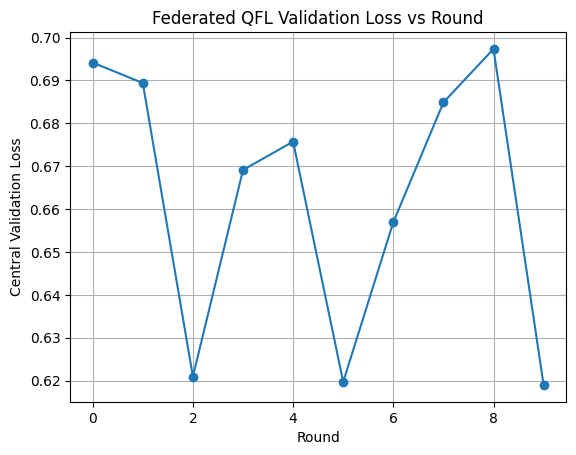

Total training time: 8757.82 s


In [26]:
print(f"Saved validation loss per round to {validation_csv_file}")
# 10) Plot validation trajectory
plt.plot(validation_loss_per_round, marker='o')
plt.xlabel('Round')
plt.ylabel('Central Validation Loss')
plt.title('Federated QFL Validation Loss vs Round')
plt.grid(True)
plt.show()

#print("Accuracy data saved to", csv_file_path)
# After loop, compute total elapsed time
total_training_time = time.time() - overall_start
print(f"Total training time: {total_training_time:.2f} s")


In [ ]:
# Define the path to save global loss
global_loss_csv = '/content/drive/My Drive/Federated_Global_Loss_22_04_2025.csv'

# Write headers to the CSV file (only at the beginning)
if epoch == 0:
    with open(global_loss_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Federated Round", "Global Loss"])

# Append the global loss after each round
with open(global_loss_csv, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([epoch, global_loss])


In [ ]:
import matplotlib.pyplot as plt

# Plot global loss over federated rounds
plt.figure(figsize=(10, 6))
plt.plot(range(len(global_loss_per_round)), global_loss_per_round, marker='o', color='blue', label="Global Loss")
plt.xlabel("Federated Round")
plt.ylabel("Global Loss")
plt.title("Global Loss Over Federated Rounds")
plt.legend()
plt.grid(True)
plt.show()


Split data as iid and non-iid

In [ ]:


#Introduce custome cross entropy function
import numpy as np

# Callback for updating learning rate dynamically with deep unfolding principles
def deep_unfolding_learning_rate_adjustment(obj_func_eval, gradients=None, client_id=None, layer=None):
    global gradient_moving_avg, learning_rates, perturbations,meta_alpha, meta_epsilon, momentum

    # Initialize moving average for gradients
    if gradients is not None:
        if not isinstance(gradient_moving_avg, np.ndarray) or gradient_moving_avg.size == 0:
            gradient_moving_avg = gradients
        else:
            # Update moving average of gradients (Momentum)
            gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients
        # Calculate the average gradient
        avg_gradient = np.mean(gradient_moving_avg)

        # Normalize delta_lr by L2 norm of the gradient
        norm_gradient = np.linalg.norm(gradients)

        '''
        # Normalization to prevent instability
        norm_gradient = gradients / (np.linalg.norm(gradients) + 1e-8)
        avg_gradient = np.mean(norm_gradient)
        '''
        # Trainable scaling for deep unfolding (meta-parameter)
        meta_alpha = 0.01  # This can be learned via a hypernetwork or meta-learning
        meta_epsilon = 1e-6  # Small offset to ensure numerical stability
        # Gradually adjust learning rate based on gradient signs and magnitude
        # This formula gradually adds or subtracts from the learning rate instead of multiplication
        delta_lr = meta_alpha * np.sign(avg_gradient) * np.sqrt(np.abs(avg_gradient) + meta_epsilon) / (norm_gradient + 1e-6)

        #delta_lr = meta_alpha * np.sign(avg_gradient) * np.sqrt(np.abs(avg_gradient) + meta_epsilon)
    # Apply gradual adjustment (either addition or subtraction based on the direction of the gradient)
        if avg_gradient > 0:
            delta_lr = delta_lr - 0.001  # Decrease if gradient is positive (potential overfitting)
        else:
            delta_lr = delta_lr + 0.001  # Increase if gradient is negative (potential underfitting)
    else:
        delta_lr = 0

    # Compute new learning rate with clamping for stability
    new_lr = max(0.001, min(5.0, learning_rates[-1] + delta_lr)) if learning_rates else initial_learning_rate

    # Update per-client, per-layer information if federated
    if client_id is not None and layer is not None:
        if client_id not in client_data:
            client_data[client_id] = {'federated_layers': {}}
        if layer not in client_data[client_id]['federated_layers']:
            client_data[client_id]['federated_layers'][layer] = {'objective_values': [], 'learning_rates': []}

        # Store loss and learning rate for the specific client and layer
        client_data[client_id]['federated_layers'][layer]['objective_values'].append(obj_func_eval)
        client_data[client_id]['federated_layers'][layer]['learning_rates'].append(new_lr)

    # Store global metrics
    objective_func_vals.append(obj_func_eval)  # Store the loss value globally
    learning_rates.append(new_lr)  # Append the new learning rate to the history

    # Update meta-parameters (meta_alpha and meta_epsilon) using gradient descent
    #meta_gradients = compute_meta_gradients(gradients, avg_gradient, delta_lr)
    #meta_alpha -= meta_learning_rate * meta_gradients['alpha']
    #meta_epsilon -= meta_learning_rate * meta_gradients['epsilon']

    # Debug output for analysis
    # print(f"Objective Function Value: {obj_func_eval:.6f}, New Learning Rate: {new_lr:.6f}")

    return new_lr


def callback_graph(weights, loss):
    """Callback to log and synchronize loss during training."""
    #print(f"Loss = {loss}")
    if len(objective_func_vals) == 0 or loss != objective_func_vals[-1]:
        objective_func_vals.append(loss)

spsa_optimizer = SPSA(maxiter=50, learning_rate=0.01, perturbation = 0.15, callback=lambda nfev, params, obj_func_eval, stepsize, accept: deep_unfolding_learning_rate_adjustment(obj_func_eval, stepsize))



# Define the CSV file path
csv_file_path = 'federated_learning_accuracy.csv'

# Open the CSV file in write mode and add headers (if starting fresh)
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Global Accuracy'] + [f'Client {i+1} Final Accuracy' for i in range(num_clients)])



new ways to average